In [292]:
import glob
from os.path import abspath 
import json

import pandas as pd 
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import pygmo as pg
import numpy as np

sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(14,8)})

# --- open several .csv files
def get_data(path):
    df_group = [pd.read_pickle(i_path) for i_path in glob.glob(path)]
    return pd.concat(df_group)

# --- unzip non-dominated results into rows
def explode_ndf(df):
    df['zip'] = df[['ndf_f', 'ndf_x']].apply(lambda row: list(zip(*row.values)), axis=1)
    df.drop(['ndf_f', 'ndf_x'], axis=1, inplace=True)
    df = df.explode('zip')
    
    df = pd.concat([df.reset_index(drop=True), 
               pd.DataFrame.from_records(df['zip'].values, columns=['obj', 'params'])],
              axis=1).drop('zip', 1)
    
    # --- column for each objective     
    obj_df = pd.DataFrame.from_records(df['obj'].values, columns=df['objectives'].iloc[0])
    df = pd.concat([df.reset_index(drop=True), obj_df],
          axis=1).drop(['obj', 'objectives'], 1)

    return df   

# --- inverse maximization metric
def inverse(cell):
    for row in range(len(cell)):
        cell[row][0] = 1 - cell[row][0] 
        
# --- Compute Hypervolume
def compute_hypervolume(row, ref_point):
    hypervolume = pg.hypervolume(row["ndf_f"]).compute(ref_point) 
    row["hypervolume"] = hypervolume
    return row

In [293]:
raw_df = get_data("results_paper/open_ml_1050/*RF*.pkl")

In [294]:
df = get_data("results_paper/open_ml_1050/*RF*.pkl")
df = explode_ndf(df)
df['dataset'] = 1050

<AxesSubplot:xlabel='iteration', ylabel='ndf_size_%'>

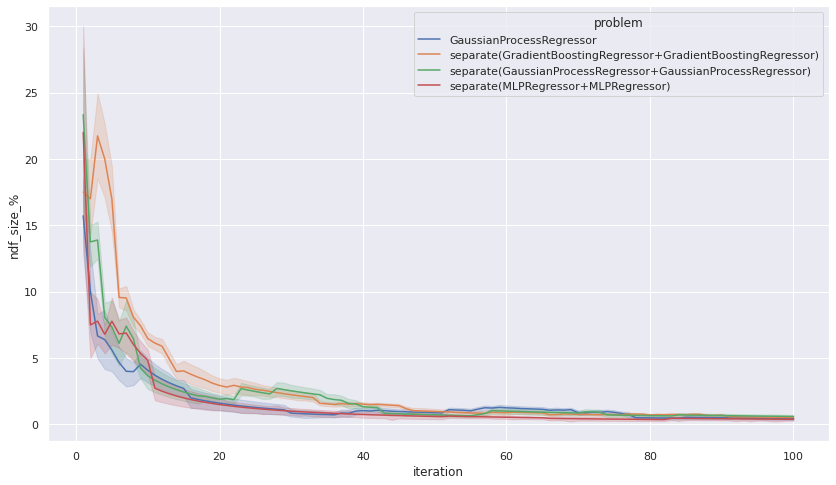

In [295]:
df['ndf_size_%'] = df['ndf_size'] / (df['iteration']*10) * 100
df['test_roc_auc_%'] = df['test_roc_auc'] * 100
df['fit_time_%'] = (1 - df['fit_time'] / df.max()["fit_time"]) * 100


sns.lineplot(x="iteration", 
             y="ndf_size_%", 
             hue="problem",
             data=df)

In [296]:
#integrate ndf_size_% surrogate-wise using the trapezodial rule
df["ndf_size_%_area"] = 0
for p in df.problem.unique():
    problem_wise_df = df[df.problem == p]
    area = np.trapz(y=problem_wise_df["ndf_size_%"], x=problem_wise_df["iteration"])
    df["ndf_size_%_area"] = df["ndf_size_%_area"].where(df.problem != p, area)

In [297]:
# Hypervolume
# find a reference point = [1 - min roc_auc, max fit_time] 
# roc_auc is inversed for minimization

df.max()["fit_time"]
ref_point = np.array([1 - df.min()["test_roc_auc"], df.max()["fit_time"]])

In [298]:
raw_df["ndf_f"].apply(lambda x: inverse(x))

0     None
1     None
2     None
3     None
4     None
      ... 
95    None
96    None
97    None
98    None
99    None
Name: ndf_f, Length: 1600, dtype: object

In [299]:
raw_df = raw_df.apply(lambda row: compute_hypervolume(row, ref_point), axis=1)

In [300]:
#integrate hypervolume surrogate-wise using the trapezodial rule
raw_df["hypervolume_area"] = 0
for p in raw_df.problem.unique():
    problem_wise_df = raw_df[raw_df.problem == p]
    area = np.trapz(y=problem_wise_df["hypervolume"], x=problem_wise_df["iteration"])
    raw_df["hypervolume_area"] = raw_df["hypervolume_area"].where(raw_df.problem != p, area)

<AxesSubplot:xlabel='iteration', ylabel='hypervolume'>

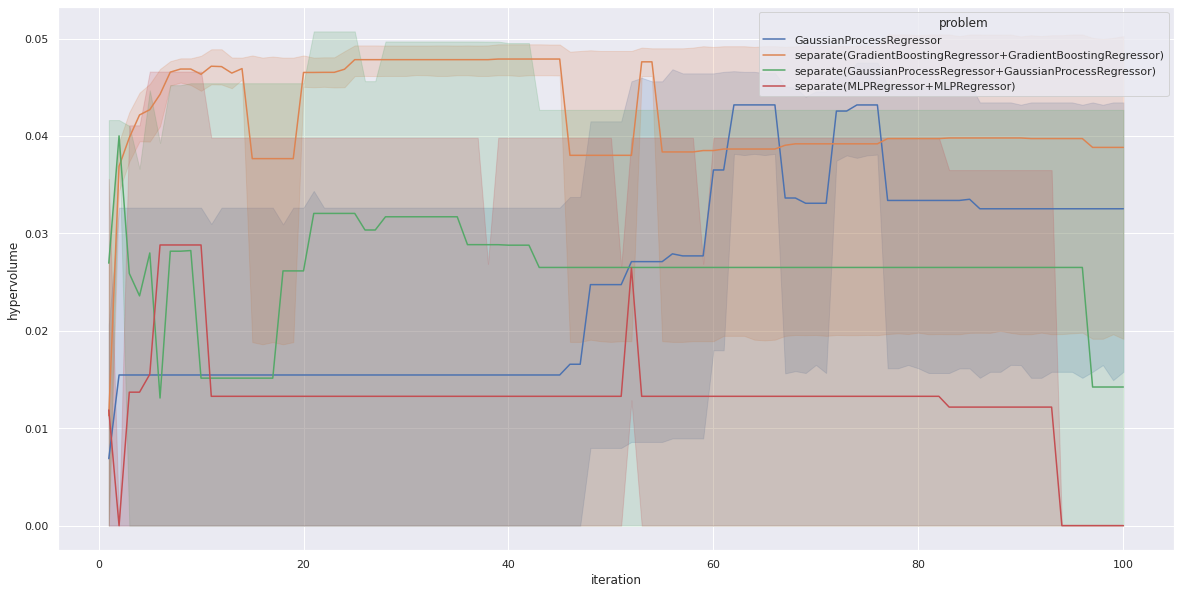

In [301]:
f, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(x="iteration", 
             y="hypervolume", 
             hue="problem",
             data=raw_df)

# sns.lineplot(x="iteration", 
#              y="test_roc_auc_%", 
# #              hue="model_id",
#              data=df)

# sns.lineplot(x="iteration", 
#              y="fit_time_%", 
# #              hue="model_id",
#              data=df)

# plt.legend(loc='upper left', labels=['ndf_size_%', 'test_roc_auc_%', 'fit_time_%'])

In [302]:
merged_df = df.merge(raw_df)
result_df = merged_df[merged_df.iteration==100]
result_df = result_df.groupby(["problem"]).mean()
result_df

,iteration,feature_dim,ndf_size,i_time,model_id,test_roc_auc,fit_time,dataset,ndf_size_%,test_roc_auc_%,fit_time_%,ndf_size_%_area,hypervolume,hypervolume_area
problem,,,,,,,,,,,,,,
GaussianProcessRegressor,100.0,7.0,4.411765,54313.866791,1.404101e+14,0.616297,0.020827,1050.0,0.441176,61.629732,88.624030,-2475.213078,0.036919,4.890700
separate(GaussianProcessRegressor+GaussianProcessRegressor),100.0,7.0,6.000000,40011.955570,1.400403e+14,0.586697,0.017849,1050.0,0.600000,58.669678,90.251057,-1040.569944,0.024391,3.582888
separate(GradientBoostingRegressor+GradientBoostingRegressor),100.0,7.0,5.210526,5909.543727,1.403937e+14,0.697036,0.020080,1050.0,0.521053,69.703623,89.032211,-2466.725261,0.046829,10.929294
separate(MLPRegressor+MLPRegressor),100.0,7.0,3.857143,1080.692571,1.404105e+14,0.500000,0.016787,1050.0,0.385714,50.000000,90.831084,-1688.633979,0.000000,2.125000


<AxesSubplot:xlabel='test_roc_auc', ylabel='fit_time'>

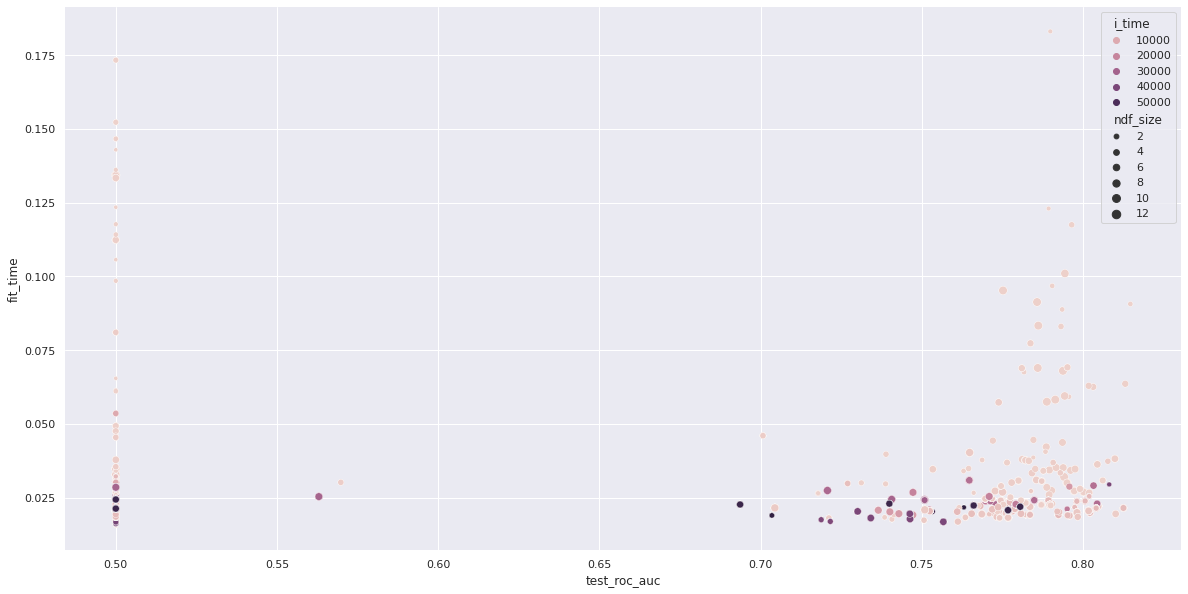

In [303]:
f, ax = plt.subplots(figsize=(20, 10))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="test_roc_auc", y="fit_time",
                hue="i_time", size="ndf_size",
                data=df, ax=ax)

## Final results: all samples

In [304]:
data = get_data("results_paper/open_ml_1049/dataset.*.pkl")
data

,criterion,max_depth,min_samples_split,min_samples_leaf,min_weight_fraction_leaf,max_features,n_estimators,fit_time,score_time,test_f1,test_roc_auc
0,gini,61.000000,0.500000,2.500000e-01,2.500000e-01,sqrt,505,0.710772,0.094134,0.000000,0.858696
1,entropy,31.000000,0.750000,1.250000e-01,3.750000e-01,sqrt,752,0.972053,0.133970,0.000000,0.500000
2,gini,90.000000,0.250000,3.750000e-01,1.250000e-01,log2,257,0.373163,0.071908,0.000000,0.500000
3,gini,46.000000,0.625000,6.250000e-02,4.375000e-01,log2,133,0.186023,0.028879,0.000000,0.836822
4,entropy,105.000000,0.125000,3.125000e-01,1.875000e-01,sqrt,628,0.862586,0.116507,0.000000,0.788737
...,...,...,...,...,...,...,...,...,...,...,...
1005,gini,103.223420,0.064604,1.843850e-11,1.532728e-15,log2,632,1.096209,0.127250,0.206705,0.918618
1006,gini,103.223420,0.212864,1.843850e-11,4.859257e-14,log2,632,0.989894,0.122440,0.000000,0.892303
1007,gini,103.972264,0.011444,1.843850e-11,3.995099e-13,log2,632,1.187727,0.132995,0.377450,0.922851
1008,gini,102.908405,0.105250,1.658110e-11,7.332780e-14,log2,632,1.052771,0.125557,0.040404,0.908569


<AxesSubplot:xlabel='test_roc_auc', ylabel='fit_time'>

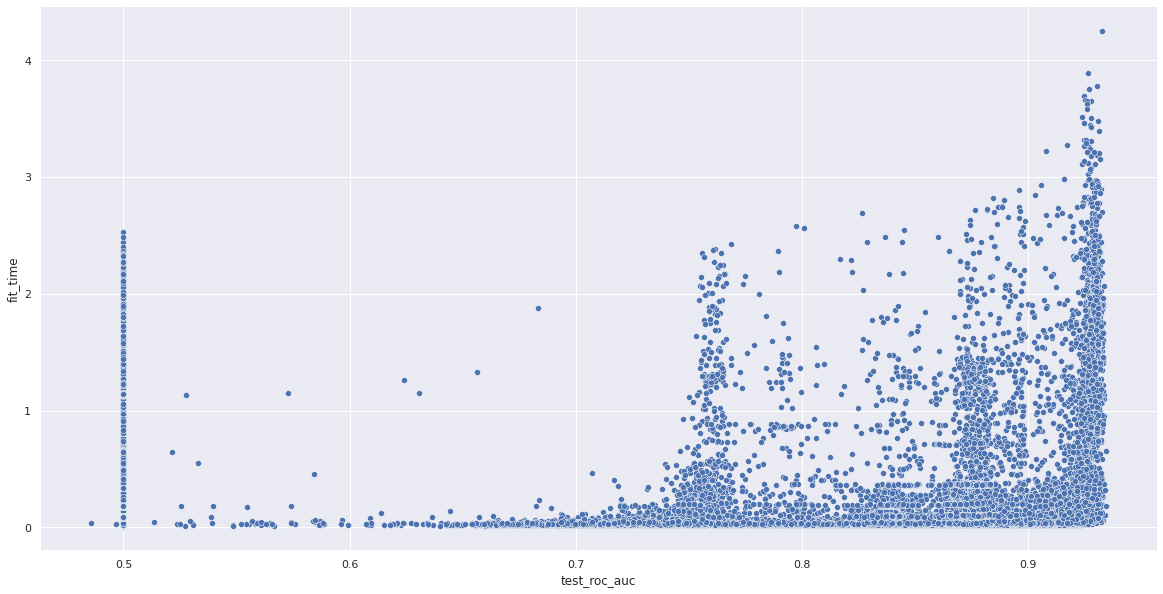

In [305]:
f, ax = plt.subplots(figsize=(20, 10))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="test_roc_auc", y="fit_time",
                data=data, ax=ax)

In [306]:
### Table dataset-wise
datasets = [1049, 1050, 31, 1471, 1510]
final_result = pd.DataFrame()
for d in datasets:
    raw_df = get_data("results_paper/open_ml_" + str(d) + "/*RF*.pkl")
    df = get_data("results_paper/open_ml_" + str(d) + "/*RF*.pkl")
    df = explode_ndf(df)
    df['ndf_size_%'] = df['ndf_size'] / (df['iteration']*10) * 100
    df['test_roc_auc_%'] = df['test_roc_auc'] * 100
    df['fit_time_%'] = (1 - df['fit_time'] / df.max()["fit_time"]) * 100
    df['dataset'] = d
    
    #integrate ndf_size_% surrogate-wise using the trapezodial rule
    df["ndf_size_%_area"] = 0
    for p in df.problem.unique():
        problem_wise_df = df[df.problem == p]
        area = np.trapz(y=problem_wise_df["ndf_size_%"], x=problem_wise_df["iteration"])
        df["ndf_size_%_area"] = df["ndf_size_%_area"].where(df.problem != p, area)
    # Hypervolume
    # find a reference point = [1 - min roc_auc, max fit_time] 
    # roc_auc is inversed for minimization

    df.max()["fit_time"]
    ref_point = np.array([1 - df.min()["test_roc_auc"], df.max()["fit_time"]])
    raw_df["ndf_f"].apply(lambda x: inverse(x))
    raw_df = raw_df.apply(lambda row: compute_hypervolume(row, ref_point), axis=1)
    #integrate hypervolume surrogate-wise using the trapezodial rule
    raw_df["hypervolume_area"] = 0
    for p in raw_df.problem.unique():
        problem_wise_df = raw_df[raw_df.problem == p]
        area = np.trapz(y=problem_wise_df["hypervolume"], x=problem_wise_df["iteration"])
        raw_df["hypervolume_area"] = raw_df["hypervolume_area"].where(raw_df.problem != p, area)
    
    
    merged_df = df.merge(raw_df)
    result_df = merged_df[merged_df.iteration==100]
    result_df = result_df.groupby(["problem", 'dataset']).mean()
    final_result = pd.concat([final_result, result_df])
final_result    


,,iteration,feature_dim,ndf_size,i_time,model_id,test_roc_auc,fit_time,ndf_size_%,test_roc_auc_%,fit_time_%,ndf_size_%_area,hypervolume,hypervolume_area
problem,dataset,,,,,,,,,,,,,
GaussianProcessRegressor,1049,100.0,7.0,4.333333,27661.534235,1.400532e+14,0.553374,0.016615,0.433333,55.337401,90.820819,-1874.365666,0.023074,1.741187
separate(GaussianProcessRegressor+GaussianProcessRegressor),1049,100.0,7.0,3.400000,68723.889818,1.402175e+14,0.544983,0.021721,0.340000,54.498282,88.000142,-1525.333174,0.016602,6.323467
separate(GradientBoostingRegressor+GradientBoostingRegressor),1049,100.0,7.0,2.272727,4423.950982,1.400756e+14,0.530121,0.015521,0.227273,53.012071,91.425261,-3081.608852,0.012259,7.423472
separate(MLPRegressor+MLPRegressor),1049,100.0,7.0,4.100000,1372.261906,1.402749e+14,0.552720,0.020239,0.410000,55.271972,88.818785,-3815.070479,0.032763,1.137636
separate(SVR+SVR),1049,100.0,7.0,2.000000,977.931064,1.403753e+14,0.500000,0.081276,0.200000,50.000000,55.099033,60.680026,0.001412,0.135184
GaussianProcessRegressor,1050,100.0,7.0,4.411765,54313.866791,1.404101e+14,0.616297,0.020827,0.441176,61.629732,88.624030,-2475.213078,0.036919,4.890700
separate(GaussianProcessRegressor+GaussianProcessRegressor),1050,100.0,7.0,6.000000,40011.955570,1.400403e+14,0.586697,0.017849,0.600000,58.669678,90.251057,-1040.569944,0.024391,3.582888
separate(GradientBoostingRegressor+GradientBoostingRegressor),1050,100.0,7.0,5.210526,5909.543727,1.403937e+14,0.697036,0.020080,0.521053,69.703623,89.032211,-2466.725261,0.046829,10.929294
separate(MLPRegressor+MLPRegressor),1050,100.0,7.0,3.857143,1080.692571,1.404105e+14,0.500000,0.016787,0.385714,50.000000,90.831084,-1688.633979,0.000000,2.125000


In [307]:
# group all datasets
final_result = final_result.groupby(["problem"]).mean()
final_result 

,iteration,feature_dim,ndf_size,i_time,model_id,test_roc_auc,fit_time,ndf_size_%,test_roc_auc_%,fit_time_%,ndf_size_%_area,hypervolume,hypervolume_area
problem,,,,,,,,,,,,,
GaussianProcessRegressor,100.0,7.0,6.578995,44283.281982,1.402940e+14,0.577786,0.037635,0.657900,57.778616,93.061705,-2967.827010,0.358827,25.612724
separate(GaussianProcessRegressor+GaussianProcessRegressor),100.0,7.0,6.246667,49456.170913,1.402581e+14,0.554650,0.039790,0.624667,55.464965,93.562998,-1458.111696,0.351462,35.482248
separate(GradientBoostingRegressor+GradientBoostingRegressor),100.0,7.0,4.974715,5113.339629,1.402995e+14,0.611075,0.019756,0.497472,61.107507,94.229342,-4036.686461,0.365610,32.513697
separate(MLPRegressor+MLPRegressor),100.0,7.0,3.888531,1214.499221,1.403195e+14,0.508039,0.034986,0.388853,50.803898,93.804125,-2656.858614,0.294470,30.962232
separate(SVR+SVR),100.0,7.0,2.000000,977.931064,1.403753e+14,0.500000,0.081276,0.200000,50.000000,55.099033,60.680026,0.001412,0.135184
